In [ ]:
#installs
#!pip install xlrd
#!pip install uncertainties

In [ ]:
#imports
import pandas as pd
import numpy as np
from uncertainties import unumpy as unp
from uncertainties import ufloat
from uncertainties.umath import *
import math
import scipy as sc
import matplotlib.pyplot as plt
from scipy import optimize
from numpy import arange
from numpy.ma.core import tan
from scipy.optimize import curve_fit
import csv

In [ ]:
#methods
def daten_fitten(funct, x_data, y_data, genauigkeit, p, min, max): #Step4/5
    #fiten
    pars, cov = curve_fit(f=funct, xdata=x_data, ydata=y_data, p0=p, bounds=[-np.inf, np.inf], maxfev=500000)
    # Get the standard deviations of the parameters (square roots of the diagonal of the covariance)
    stdevs = np.sqrt(np.diag(cov))
    print('Fitparameter')
    print(pars)
    print('zugehörige Uncertainty')
    print(stdevs)
    #datensets
    xfit = np.linspace(min, max, genauigkeit)
    yfit = funct(xfit, *pars)
    return pars, stdevs, xfit, yfit


Defintionswerte

In [ ]:
WellenlängeLaser = 633e-9 #m

DistanceA = ufloat(11.3, 0.2) #cm
DistanceB = ufloat(15.5, 0.2) #cm
DistanceC = ufloat(25.6, 0.2) #cm
DistanceD = ufloat(138.5, 0.2) #cm
DistanceGes = DistanceA + DistanceB + DistanceD

background = ufloat(7.433, 0.26)

Pin = ufloat(906.9, 0.062)
Pin_background = ufloat(5.881, 0.0074)
Pin = Pin - Pin_background

Pout = ufloat(858.3, 0.293)
Pout_background = ufloat(5.289, 0.01428)
Pout = Pout - Pout_background

V0 = 632 #mV
Verstärker = ufloat(33.4, 0.2) #dBm

Aufgabe 3.1

In [ ]:
InsertionLoss = 1- (Pout/Pin)

print('Insertion loss:', InsertionLoss)

Abstand = ufloat(2, 0.1) #cm

BraggAngle = unp.arctan(Abstand/DistanceGes)/2

print('Bragg-Angle:', BraggAngle, 'Rad')

Insertion loss: 0.05328+/-0.00033
Bragg-Angle: 0.00605+/-0.00030 Rad


Aufgabe 3.2

In [ ]:
#Daten einlesen
data2 = pd.read_excel('Daten Aufgabe 3.2.xlsx')

#converte dataframe to array
data2 = data2.values

In [ ]:
#data to uarray with uncertainties
u1Order = unp.uarray(data2[:,1], data2[:,2])
u1Order = np.column_stack((u1Order, data2[:,0]))
u1Order[:, 0] -= background

Zeropoint_row = np.array([ufloat(0,0), 0])
u1Order = np.vstack([u1Order, Zeropoint_row])

Effizienz_column = u1Order[:, 0] / Pout
u1Order = np.hstack((u1Order, Effizienz_column[:, np.newaxis]))

RFLeistung_column = (u1Order[:, 1]/V0)**2 * 10**(Verstärker/10)
u1Order = np.hstack((u1Order, RFLeistung_column[:, np.newaxis]))

u0Order = unp.uarray(data2[:,3], data2[:,4])
u0Order = np.column_stack((u0Order, data2[:,0]))
u0Order[:, 0] -= background

Zeropoint_row = np.array([Pout, 0])
u0Order = np.vstack([u0Order, Zeropoint_row])

Effizienz_column = u0Order[:, 0] / Pout
u0Order = np.hstack((u0Order, Effizienz_column[:, np.newaxis]))

RFLeistung_column = (u0Order[:, 1]/V0)**2 * 10**(Verstärker/10)
u0Order = np.hstack((u0Order, RFLeistung_column[:, np.newaxis]))

Fitparameter
[9.34758544e-01 1.29080192e+03]
zugehörige Uncertainty
[5.53125725e-03 1.74795098e+01]
Fitparameter
[9.57399187e-01 1.35077201e+03 1.04327623e-02]
zugehörige Uncertainty
[1.17423667e-02 1.86163475e+01 5.23359723e-03]


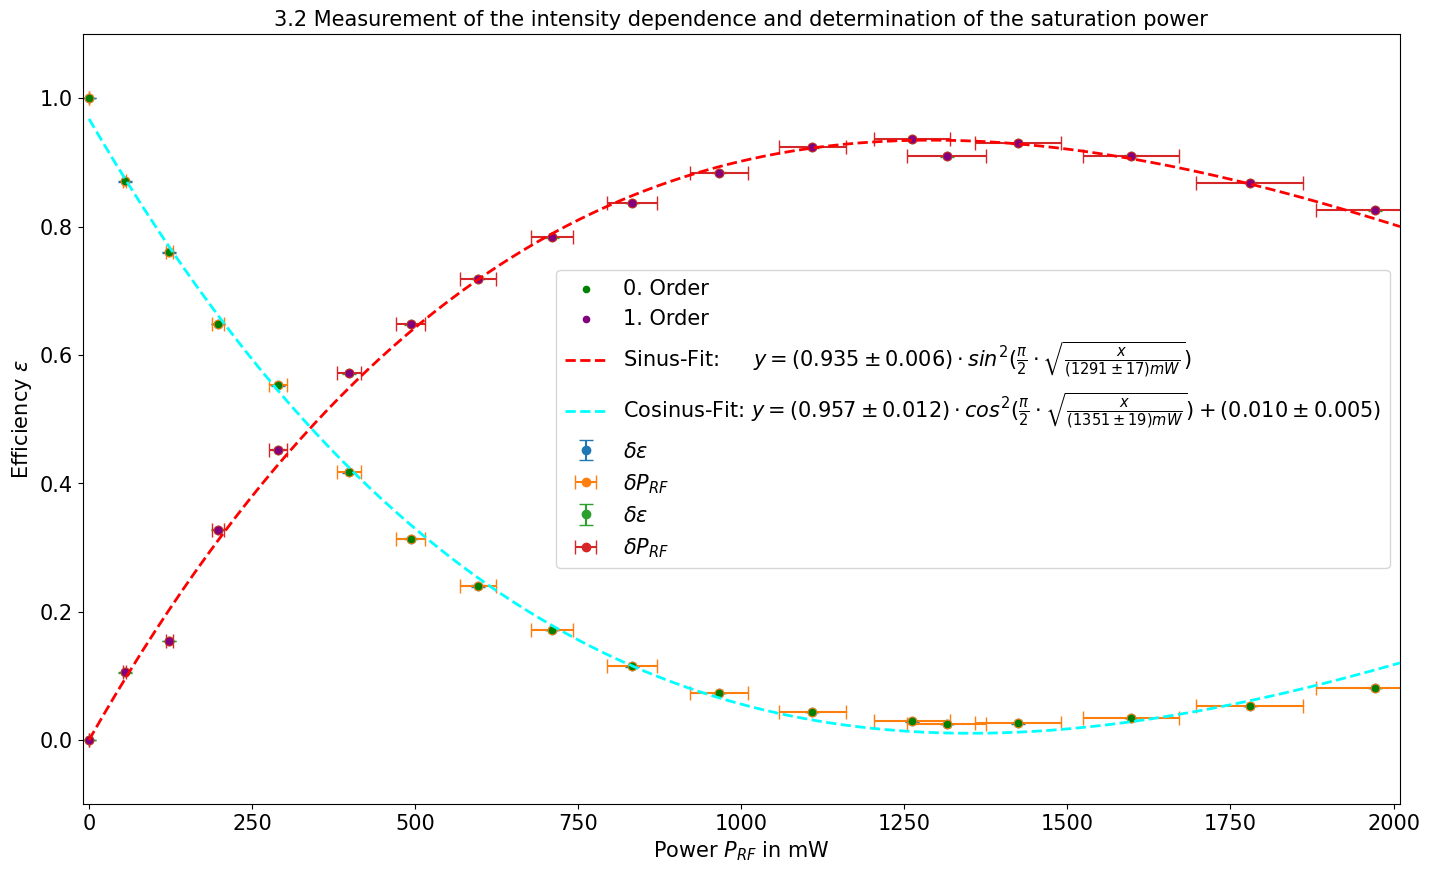

In [ ]:
def sin(x, a, Psat):
  return a*(np.sin(np.pi/2 * np.sqrt(x/Psat)))**2

def cos(x, a, Psat, b):
  return a*(np.cos(np.pi/2 * np.sqrt(x/Psat)))**2 + b

plt.subplots(1,1,figsize=(17, 10));

y0 = [float(i[2].nominal_value) for i in u0Order]
x0 = [float(i[3].nominal_value) for i in u0Order]

plt.scatter(x0, y0, color='green', s=20, label='0. Order', zorder= 5)

y_error0 = [float(i[2].std_dev) for i in u0Order]
x_error0 = [float(i[3].std_dev) for i in u0Order]

plt.errorbar(x0, y0, yerr=y_error0, fmt='o', capsize=5, label = r'$δ \epsilon$')
plt.errorbar(x0, y0, xerr=x_error0, fmt='o', capsize=5, label = r'$δ P_{RF}$')

y1 = [float(i[2].nominal_value) for i in u1Order]
x1 = [float(i[3].nominal_value) for i in u1Order]

plt.scatter(x1, y1, color='purple', s=20, label='1. Order', zorder= 5)

y_error1 = [float(i[2].std_dev) for i in u1Order]
x_error1 = [float(i[3].std_dev) for i in u1Order]

plt.errorbar(x1, y1, yerr=y_error1, fmt='o', capsize=5, label = r'$δ \epsilon$')
plt.errorbar(x1, y1, xerr=x_error1, fmt='o', capsize=5, label = r'$δ P_{RF}$')

pars, stdevs, xfit, yfit = daten_fitten(sin, x1, y1, 100, [1, 1300], 0 , 2010)
plt.plot(xfit, yfit, '--', color='red', label = r'Sinus-Fit:     $ y = (%.3f \pm %.3f) \cdot sin^2(\frac{\pi}{2} \cdot \sqrt{\frac{x}{(%.0f \pm %.0f)mW}})$'%(pars[0], stdevs[0], pars[1], stdevs[1]), zorder= 6, linewidth=2)

pars, stdevs, xfit, yfit = daten_fitten(cos, x0, y0, 100, [1, 1300, 1], 0 , 2010)
plt.plot(xfit, yfit, '--', color='cyan', label = r'Cosinus-Fit: $ y = (%.3f \pm %.3f) \cdot cos^2(\frac{\pi}{2} \cdot \sqrt{\frac{x}{(%.0f \pm %.0f)mW}}) + (%.3f \pm %.3f)$'%(pars[0], stdevs[0], pars[1], stdevs[1], pars[2], stdevs[2]), zorder= 6, linewidth=2)

plt.xlabel(r'Power $P_{RF}$ in mW', fontsize=15)
plt.ylabel(r'Efficiency $\epsilon$', fontsize=15)
plt.title('3.2 Measurement of the intensity dependence and determination of the saturation power', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Display the plot
plt.legend(loc = 'center right', fontsize=15)
plt.axis([-10, 2010, -0.1, 1.1]) #Achsenanpassung
plt.show()

Aufgabe 3.3

In [ ]:
#Daten einlesen
data3 = pd.read_excel('Daten Aufgabe 3.3.xlsx')

#converte dataframe to array
data3 = data3.values

In [ ]:
#data to uarray with uncertainties
uA3_Leistung = unp.uarray(data3[:,1], data3[:,2])
uA3 = np.column_stack((uA3_Leistung, data3[:,0]))

uncertainty_array= np.full(len(data3), 0.1)

uA3_Abstand = unp.uarray(data3[:,3], uncertainty_array)
uA3 = np.column_stack((uA3, uA3_Abstand))

uA3[:, 0] -= background

f0 = 80 #MHz
Frequenzverstimmung_column = uA3[:, 1] / f0
uA3 = np.hstack((uA3, Frequenzverstimmung_column[:, np.newaxis]))

Effizienz_column = uA3[:, 0] / Pout
uA3 = np.hstack((uA3, Effizienz_column[:, np.newaxis]))

Fitparameter
[3.26816427 0.62258445]
zugehörige Uncertainty
[0.55827474 0.01589428]


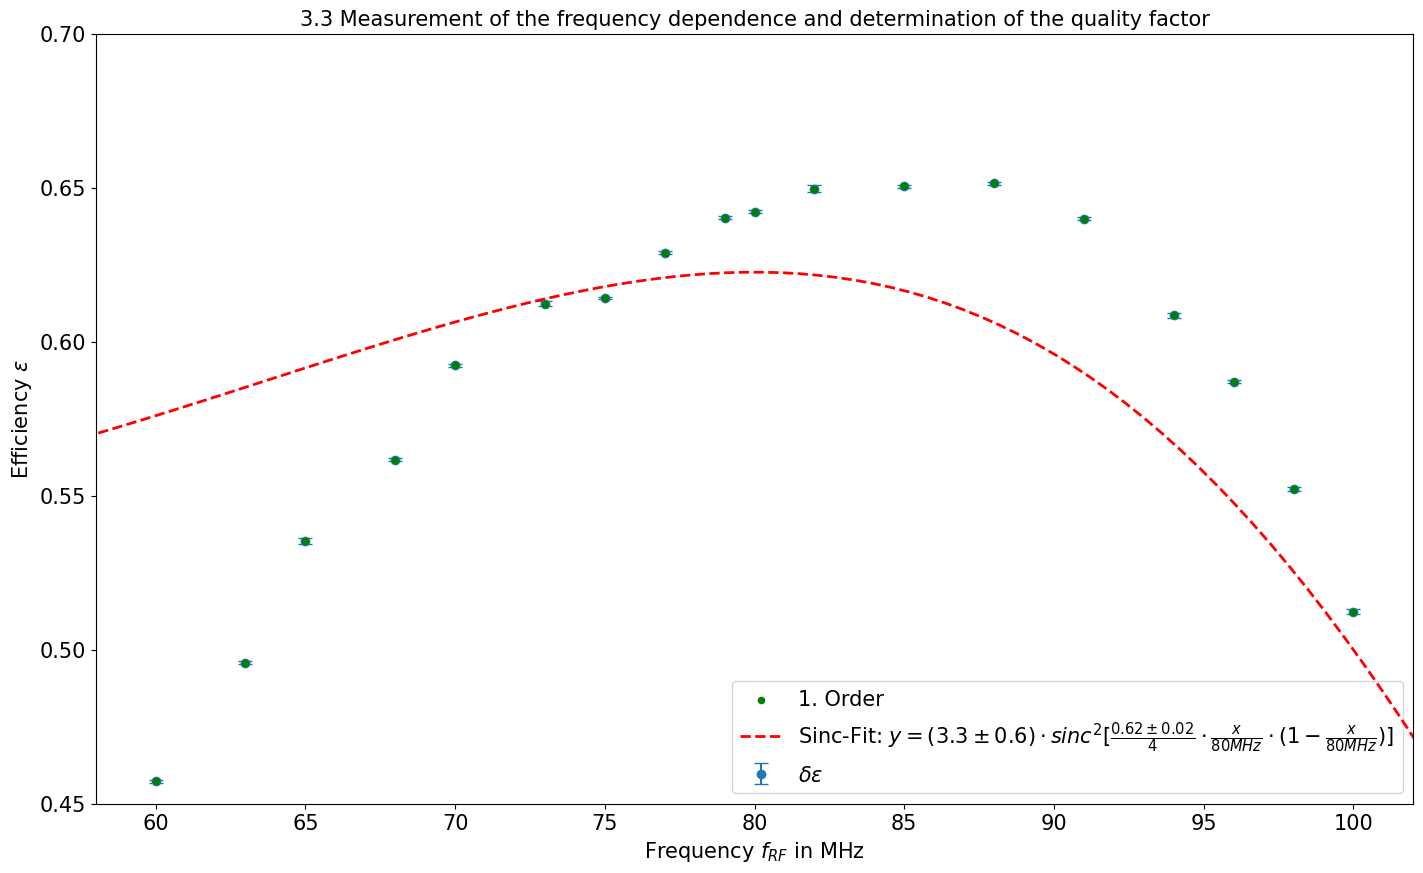

In [ ]:
def sinc(x, Q, a):
  return a*(np.sinc((Q/4)*(x/f0)*(1-(x/f0))))**2

plt.subplots(1,1,figsize=(17, 10));

y = [float(i[4].nominal_value) for i in uA3]
x = [float(i[1]) for i in uA3]

plt.scatter(x, y, color='green', s=20, label='1. Order', zorder= 5)

y_error = [float(i[4].std_dev) for i in uA3]

plt.errorbar(x, y, yerr=y_error, fmt='o', capsize=5, label = r'$δ\epsilon$')


pars, stdevs, xfit, yfit = daten_fitten(sinc, x, y, 100, [5, 1], 50, 110)
plt.plot(xfit, yfit, '--', color='red', label = r'Sinc-Fit: $ y = (%.1f \pm %.1f) \cdot sinc^2[\frac{%.2f \pm %.2f}{4} \cdot \frac{x}{80MHz} \cdot (1-\frac{x}{80MHz})]$'%(pars[0], stdevs[0], pars[1], stdevs[1]), zorder= 6, linewidth=2)

plt.xlabel(r'Frequency $f_{RF}$ in MHz', fontsize=15)
plt.ylabel(r'Efficiency $\epsilon$', fontsize=15)
plt.title('3.3 Measurement of the frequency dependence and determination of the quality factor', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Display the plot
plt.legend(loc = 'lower right', fontsize=15)
plt.axis([58, 102, 0.45, 0.7]) #Achsenanpassung
plt.show()

Fitparameter
[ 5.7260441   0.66234818 85.60759627]
zugehörige Uncertainty
[0.15849514 0.00505443 0.28489408]


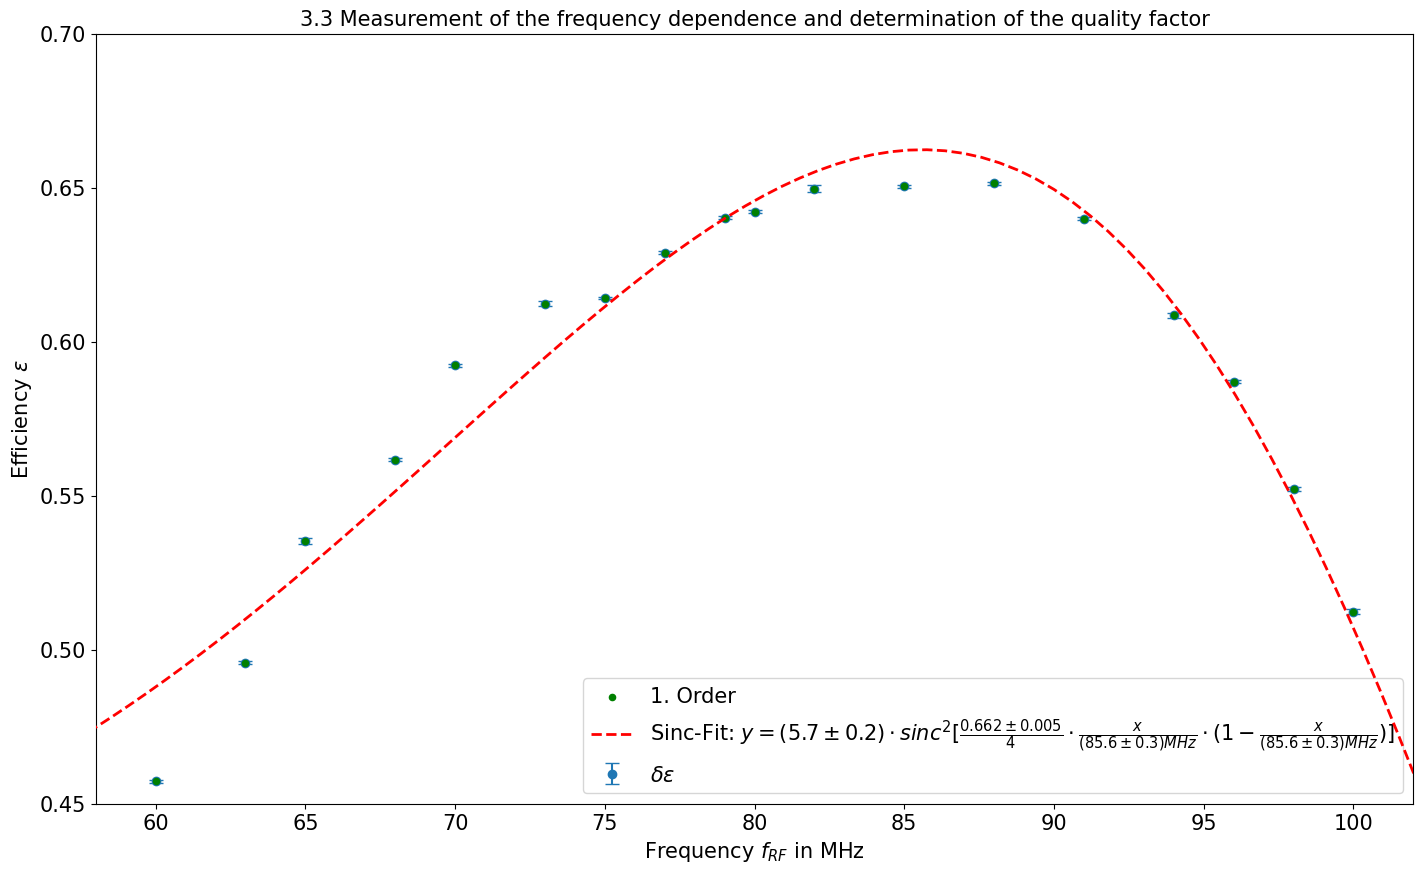

In [ ]:
def sinc(x, Q, a, f):
  return a*(np.sinc((Q/4)*(x/f)*(1-(x/f))))**2

plt.subplots(1,1,figsize=(17, 10));

y = [float(i[4].nominal_value) for i in uA3]
x = [float(i[1]) for i in uA3]

plt.scatter(x, y, color='green', s=20, label='1. Order', zorder= 5)

y_error = [float(i[4].std_dev) for i in uA3]

plt.errorbar(x, y, yerr=y_error, fmt='o', capsize=5, label = r'$δ\epsilon$')


pars, stdevs, xfit, yfit = daten_fitten(sinc, x, y, 100, [5, 0.6, 80], 50, 110)
plt.plot(xfit, yfit, '--', color='red',  label = r'Sinc-Fit: $ y = (%.1f \pm %.1f) \cdot sinc^2[\frac{%.3f \pm %.3f}{4} \cdot \frac{x}{(%.1f \pm %.1f)MHz} \cdot (1-\frac{x}{(%.1f \pm %.1f)MHz})]$'%(pars[0], stdevs[0], pars[1], stdevs[1], pars[2], stdevs[2], pars[2], stdevs[2]), zorder= 6, linewidth=2)

plt.xlabel(r'Frequency $f_{RF}$ in MHz', fontsize=15)
plt.ylabel(r'Efficiency $\epsilon$', fontsize=15)
plt.title('3.3 Measurement of the frequency dependence and determination of the quality factor', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Display the plot
plt.legend(loc = 'lower right', fontsize=15)
plt.axis([58, 102, 0.45, 0.7]) #Achsenanpassung
plt.show()

In [ ]:
Angle_column = unp.tan(uA3[:,2]/DistanceGes)
uA3 = np.hstack((uA3, Angle_column[:, np.newaxis]))

Fitparameter
[0.00013495 0.00137478]
zugehörige Uncertainty
[5.60677650e-06 4.54867427e-04]


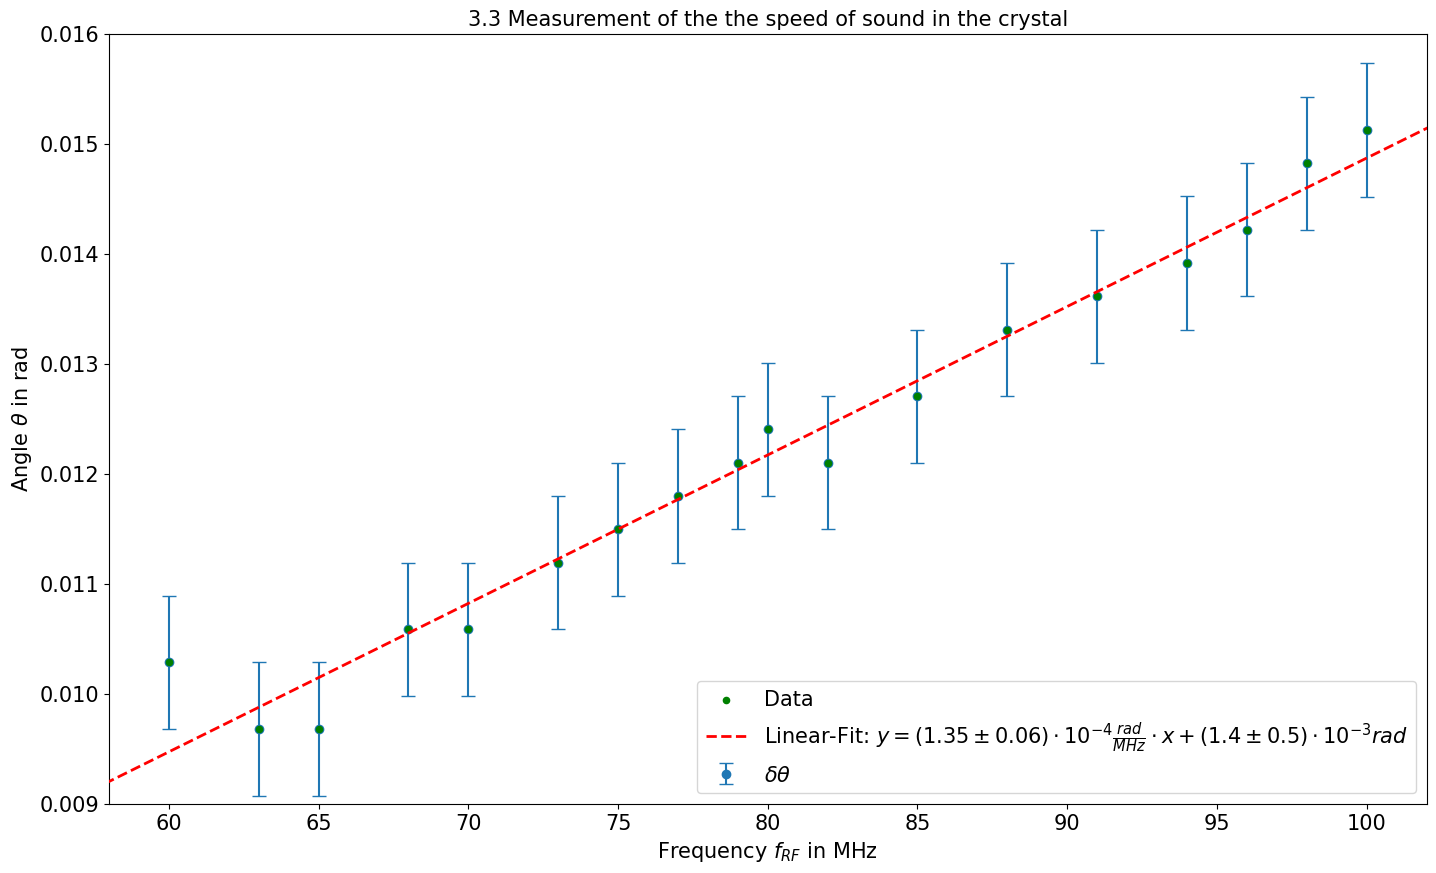

In [ ]:
def line(x, a, b):
  return a*x + b

plt.subplots(1,1,figsize=(17, 10));

y = [float(i[5].nominal_value) for i in uA3]
x = [int(i[1]) for i in uA3]

plt.scatter(x, y, color='green', s=20, label='Data', zorder= 5)

y_error = [float(i[5].std_dev) for i in uA3]

plt.errorbar(x, y, yerr=y_error, fmt='o', capsize=5, label = r'$δ\theta$')



pars, stdevs, xfit, yfit = daten_fitten(line, x, y, 100, [1, 1], 50 ,110)
plt.plot(xfit, yfit, '--', color='red', label = r'Linear-Fit: $ y = (%.2f \pm %.2f)\cdot 10^{-4} \frac{rad}{MHz} \cdot x + (%.1f \pm %.1f)\cdot 10^{-3} rad$'%(pars[0]*10000, stdevs[0]*10000, pars[1]*1000, stdevs[1]*1000), zorder= 6, linewidth=2)

plt.xlabel(r'Frequency $f_{RF}$ in MHz', fontsize=15)
plt.ylabel(r'Angle $\theta$ in rad', fontsize=15)
plt.title('3.3 Measurement of the the speed of sound in the crystal', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Display the plot
plt.legend(loc = 'lower right', fontsize=15)
plt.axis([58, 102, 0.009, 0.016]) #Achsenanpassung
plt.show()

In [ ]:
SteigungA = ufloat(pars[0], stdevs[0])
vSchall = WellenlängeLaser*10**6/SteigungA
print('Schallgeschwindigkeit im Kristall:', vSchall, 'm/s')

Schallgeschwindigkeit im Kristall: (4.69+/-0.19)e+03 m/s


Aufgabe 3.4

In [ ]:
#Daten einlesen
data4 = pd.read_excel('Daten Aufgabe 3.4.xlsx')

#converte dataframe to array
data4 = data4.values
data4 = np.delete(data4, 1, axis=1)

In [ ]:
#data to uarray with uncertainties
uA4_Leistung = unp.uarray(data4[:,1], data4[:,2])
uA4 = np.column_stack((uA4_Leistung, data4[:,0]))

uA4[:, 0] -= background

uncertainty_array= np.full(len(data4), 0.25)
uA4Ticks = unp.uarray(uA4[:, 1], uncertainty_array)
uA4 = np.column_stack((uA4, uA4Ticks))

TicksToRad_column = ((uA4[:, 2] + 1) / 25) * np.pi/180
uA4 = np.hstack((uA4, TicksToRad_column[:, np.newaxis]))


Effizienz_column = uA4[:, 0] / Pout
uA4 = np.hstack((uA4, Effizienz_column[:, np.newaxis]))

Fitparameter
[4.10774274 0.64526284 0.0072183 ]
zugehörige Uncertainty
[0.04720872 0.00665425 0.00329889]


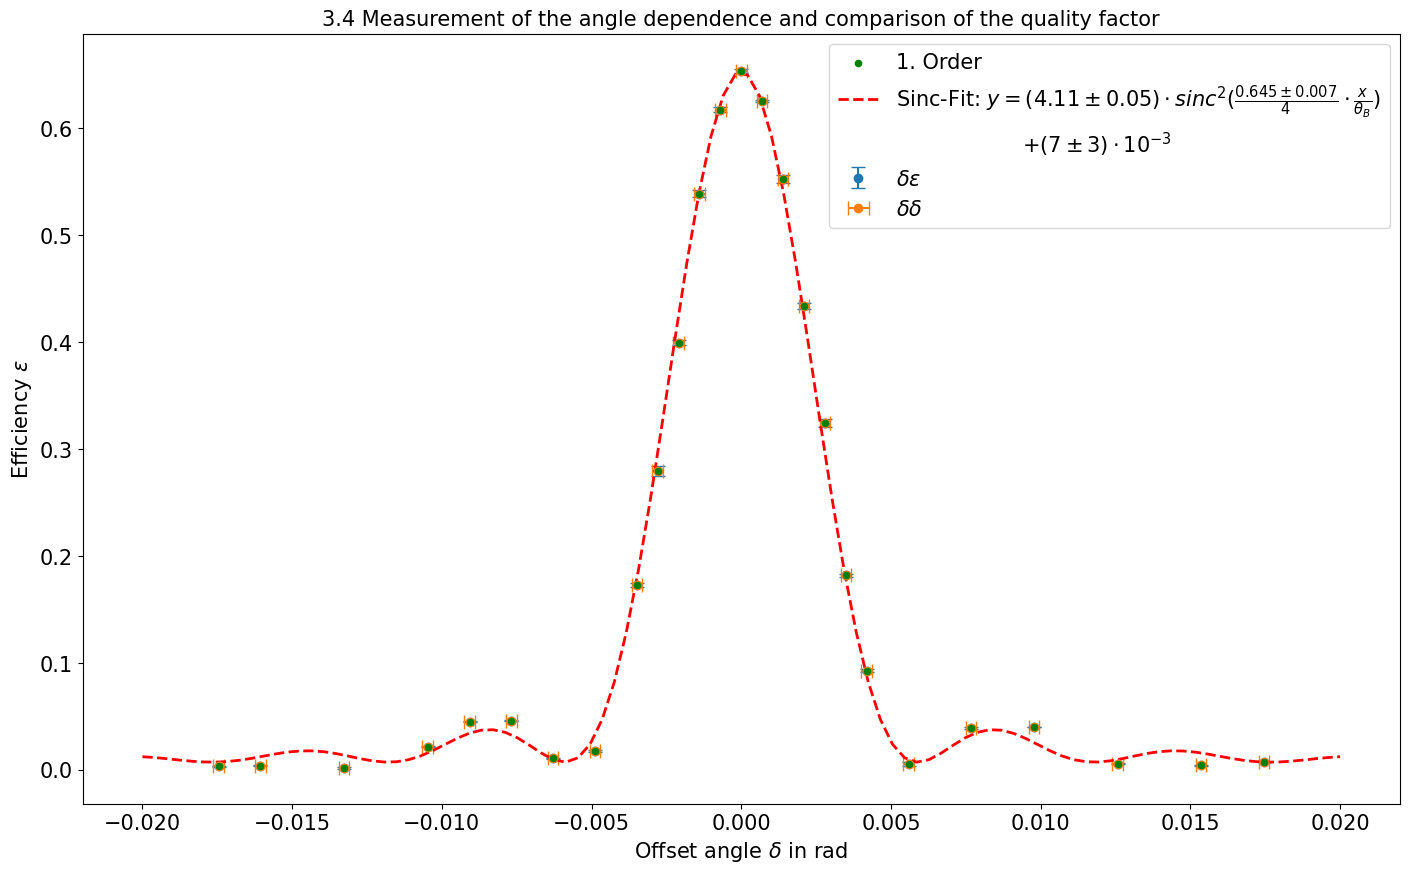

In [ ]:
def sinc(x, Q, a, c):
  return  a*(np.sinc((Q/4)*(x/BraggAngle.nominal_value)))**2 + c

plt.subplots(1,1,figsize=(17, 10));

y = [float(i[4].nominal_value) for i in uA4]
x = [float(i[3].nominal_value) for i in uA4]

plt.scatter(x, y, color='green', s=20, label='1. Order', zorder= 5)

y_error = [float(i[4].std_dev) for i in uA4]
x_error = [float(i[3].std_dev) for i in uA4]

plt.errorbar(x, y, yerr=y_error, fmt='o', capsize=5, label = r'$δ\epsilon$')
plt.errorbar(x, y, xerr=x_error, fmt='o', capsize=5, label = r'$δ\delta$')

pars, stdevs, xfit, yfit = daten_fitten(sinc, x, y, 100, [1, 1, 1], -0.02, 0.02)
plt.plot(xfit, yfit, '--', color='red', label = r'Sinc-Fit: $ y = (%.2f \pm %.2f) \cdot sinc^2(\frac{%.3f \pm %.3f}{4} \cdot \frac{x}{\theta_B})$'%(pars[0], stdevs[0], pars[1], stdevs[1]), zorder= 2, linewidth=2)
plt.plot([], [], ' ', label = r'                   $+ (%.0f \pm %.0f) \cdot 10^{-3}$' % ( pars[2]*1000, stdevs[2]*1000))

plt.xlabel(r'Offset angle $\delta$ in rad', fontsize=15)
plt.ylabel(r'Efficiency $\epsilon$', fontsize=15)
plt.title('3.4 Measurement of the angle dependence and comparison of the quality factor', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Display the plot
plt.legend(loc = 'upper right', fontsize=15)
#plt.axis([0, 310, 0.1, 500]) #Achsenanpassung
plt.show()

In [ ]:
Q = ufloat(pars[0], stdevs[0])
print('Qualitätsfaktor Q:', Q)

Qualitätsfaktor Q: 4.11+/-0.05


Aufgabe 3.5

In [ ]:
#Daten einlesen
data5 = pd.read_excel('Daten Aufgabe 3.5.xlsx')

#converte dataframe to array
data5 = data5.values

In [ ]:
#data to uarray with uncertainties
uncertainty_array= np.full(len(data5), 1)

uA5_Leistung = unp.uarray(data5[:,1], uncertainty_array)
uA5 = np.column_stack((uA5_Leistung, data5[:,0]))
uA5 = np.delete(uA5, 6, axis=0)

uA5[:, 0] -= background

Effizienz_column = uA5[:, 0] / Pout
uA5 = np.hstack((uA5, Effizienz_column[:, np.newaxis]))

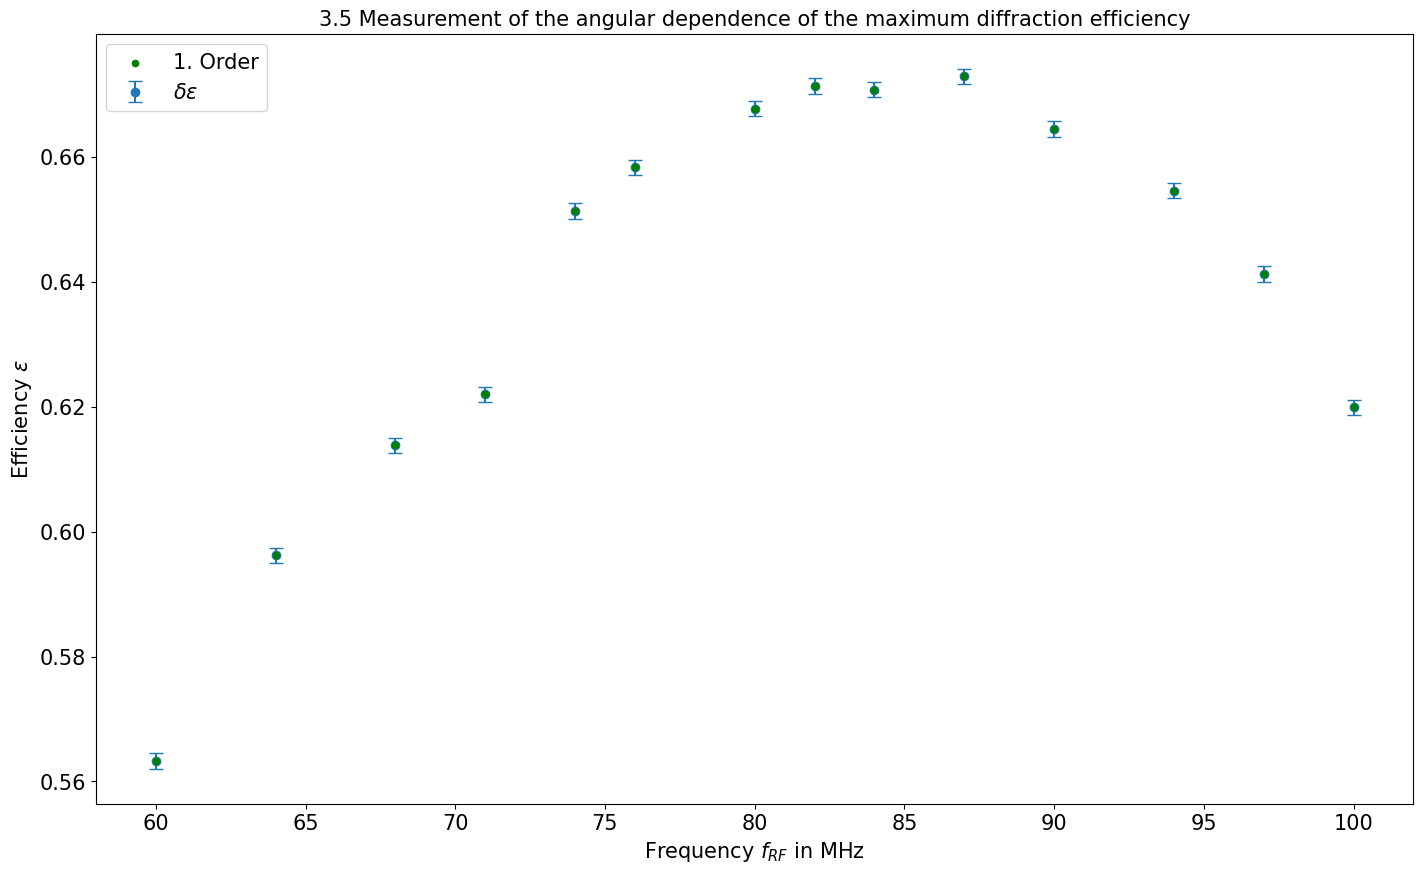

In [ ]:
def sinc(x, Q, a, f):
  return a*(np.sinc((Q/4)*(x/f)*(1-(x/f))))**2

plt.subplots(1,1,figsize=(17, 10));

y = [float(i[2].nominal_value) for i in uA5]
x = [int(i[1]) for i in uA5]

plt.scatter(x, y, color='green', s=20, label='1. Order', zorder= 5)

y_error = [float(i[2].std_dev) for i in uA5]

plt.errorbar(x, y, yerr=y_error, fmt='o', capsize=5, label = r'$δ\epsilon$')



#pars, stdevs, xfit, yfit = daten_fitten(sinc, x, y, 100, [5, 0.6, 80], 60 ,100)
#plt.plot(xfit, yfit, '--', color='red', label = r'Exponential-Fit:$ y = (%.0f \pm %.0f) \cdot exp({(%.4f \pm %.4f) \frac{1}{ms} \cdot x})$'%(pars[0], stdevs[0], pars[1], stdevs[1]), zorder= 6, linewidth=3)

plt.xlabel(r'Frequency $f_{RF}$ in MHz', fontsize=15)
plt.ylabel(r'Efficiency $\epsilon$', fontsize=15)
plt.title('3.5 Measurement of the angular dependence of the maximum diffraction efficiency', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Display the plot
plt.legend(loc = 'upper left', fontsize=15)
#plt.axis([0, 310, 0.1, 500]) #Achsenanpassung
plt.show()